In [1]:
# !pip install -U imbalanced-learn
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import string, re
import nltk
from nltk import word_tokenize
import spacy
from nltk.stem.porter import PorterStemmer

from imblearn.over_sampling import SMOTE



from sklearn.datasets import fetch_20newsgroups
from sklearn.utils import class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.backend import clear_session

In [4]:
nltk.download('punkt')
string.punctuation

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [5]:
news = fetch_20newsgroups(subset='all')

In [6]:
def fetch_data(data, slope=1000):

    remainder = slope
    data_l = []
    batches = len(data.data) // slope + 1

    for i in range(batches):

        x = i * slope

        if i == batches - 1:
            remainder = len(data.data) % slope
        
        datas = np.c_[data.data[x:x + remainder], data.target[x:x + remainder]]
        data_l.append(pd.DataFrame(datas, columns=['text', 'target']))
    
    return pd.concat(data_l)

In [7]:
df = fetch_data(news)

In [8]:
def preprocess(df, col_name='text'):
    
    column = df[col_name].tolist()
    puncs = string.punctuation
    sp = spacy.load('en_core_web_sm')
    stp_wrds = sp.Defaults.stop_words
    txt = ''
    stemmer = PorterStemmer()
    result = []

    for each_txt in column:
        txt = each_txt.lower()
        txt = re.sub(r'\n', ' ', txt)
        txt = re.sub(r'\s{2,}', ' ', txt)
        mytable = txt.maketrans('', '', puncs)
        txt = txt.translate(mytable)
        tokens = txt.split(' ')
        tokens = [word for word in tokens if not word in stp_wrds]
        tokens = [word for word in tokens if  word.isalpha()]
        tokens = [stemmer.stem(each) for each in tokens]
        result.append(' '.join(tokens))

    df['Cleaned_' + col_name] = result
    return df

In [9]:
df = preprocess(df, 'text')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18846 entries, 0 to 845
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          18846 non-null  object
 1   target        18846 non-null  object
 2   Cleaned_text  18846 non-null  object
dtypes: object(3)
memory usage: 588.9+ KB


In [11]:
X, y = df.Cleaned_text, df.target
sm = SMOTE()

tfidf = TfidfVectorizer()
tfidf.fit(X, y)

X_vec = tfidf.transform(X)
X_sm, y_sm = sm.fit_resample(X_vec, y)

x_tr, x_ts, y_tr, y_ts = train_test_split(X_sm, y_sm, test_size=0.2, stratify=y_sm)

In [12]:
def fit_model(X, x_train, x_test, y_train, y_test, report=True, draw_heatmap=True):

    model = X
    model.fit(x_train, y_train)

    pred = model.predict(x_test)
    
    if report:
        print(classification_report(list(y_test), pred))
        
    if draw_heatmap:
        print()
        matrix = confusion_matrix(list(y_test), pred)

        sns.set()
        plt.figure(figsize = (15, 15))

        sns.heatmap(matrix.T,
                    square = True,
                    annot = True,
                    fmt = 'd',
                    cbar = False,
                    linewidths = .9,
                    xticklabels = np.unique(y_train).tolist(),
                    yticklabels = np.unique(y_train).tolist())

        plt.xlabel('Truth')
        plt.ylabel('Predicted')

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       199
           1       0.86      0.83      0.85       200
          10       0.95      0.98      0.97       200
          11       0.89      0.97      0.93       200
          12       0.92      0.83      0.87       200
          13       0.96      0.91      0.93       200
          14       0.97      0.97      0.97       199
          15       0.89      0.91      0.90       200
          16       0.83      0.97      0.89       200
          17       0.94      0.99      0.96       199
          18       0.92      0.87      0.89       200
          19       0.89      0.76      0.82       200
           2       0.86      0.85      0.86       200
           3       0.76      0.87      0.81       200
           4       0.88      0.91      0.90       199
           5       0.92      0.91      0.91       200
           6       0.93      0.81      0.87       200
           7       0.96    

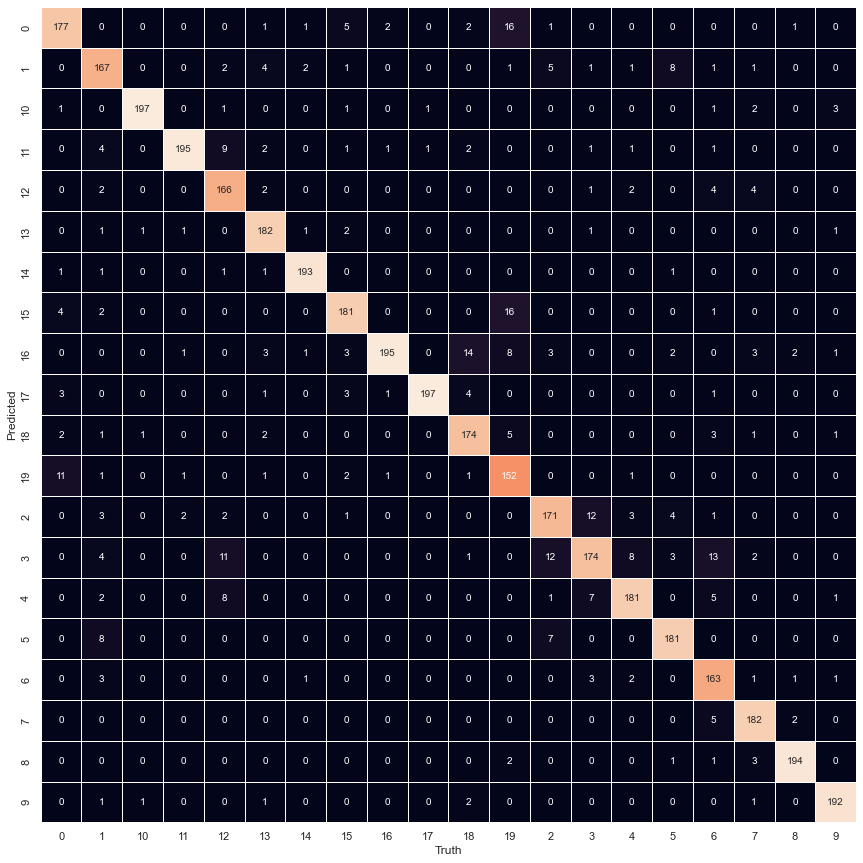

In [13]:
fit_model(MultinomialNB(), x_tr, x_ts, y_tr, y_ts)

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       199
           1       0.78      0.86      0.82       200
          10       0.98      0.97      0.98       200
          11       0.97      0.94      0.96       200
          12       0.85      0.88      0.86       200
          13       0.93      0.95      0.94       200
          14       0.99      0.96      0.97       199
          15       0.92      0.91      0.91       200
          16       0.92      0.93      0.92       200
          17       0.95      0.98      0.97       199
          18       0.93      0.88      0.90       200
          19       0.88      0.87      0.88       200
           2       0.81      0.82      0.82       200
           3       0.81      0.81      0.81       200
           4       0.87      0.88      0.88       199
           5       0.89      0.88      0.89       200
           6       0.85      0.90      0.87       200
           7       0.94    

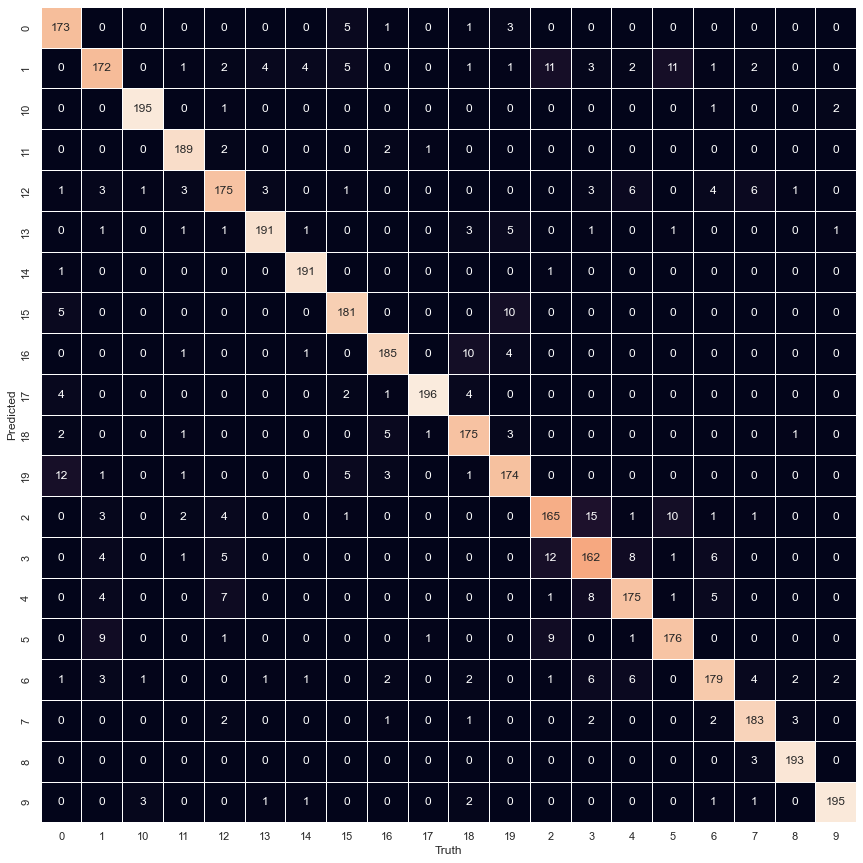

In [14]:
fit_model(LogisticRegression(solver='newton-cg', class_weight='balanced'), x_tr, x_ts, y_tr, y_ts)

In [15]:
X, y = df.Cleaned_text, df.target.astype(int)

text_train, text_test, target_train, target_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [16]:
MAX_WORDS = 10000
MAX_SEQUENCES = 1000


keras_tokenizer = Tokenizer(num_words = MAX_WORDS, oov_token="<OOV>")
keras_tokenizer.fit_on_texts(text_train)

word_index = keras_tokenizer.word_index
vocab_size = len(word_index)
train_sequences = keras_tokenizer.texts_to_sequences(text_train)
train_sequences_padded = pad_sequences(train_sequences, maxlen = MAX_SEQUENCES, padding='post', truncating='post')

test_sequences = keras_tokenizer.texts_to_sequences(text_test)
test_sequences_padded = pad_sequences(test_sequences, maxlen = MAX_SEQUENCES, padding='post', truncating='post')

In [17]:
train_sequences_padded = np.array(train_sequences_padded)
target_train = np.array(target_train)

test_sequences_padded = np.array(test_sequences_padded)
target_test = np.array(target_test)

In [24]:
def make_NN(x_train, x_test, y_train, y_test, vocab_size, embedding_dim=30, epochs=50):

    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=MAX_SEQUENCES),
    # tf.keras.layers.Bidirectional(LSTM(128)),
    tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='softmax')
    ])
    model_path='best_model.h5'
    model_checkpoint = ModelCheckpoint(filepath=model_path, save_best_only=True, mode='min')
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    print()

    history = model.fit(x_train, y_train,
                    epochs=epochs,
                    verbose='auto',
                    validation_split=0.25,
                    batch_size=128,
                    callbacks=[model_checkpoint])
    
    predicted_texts = model.predict(x_test)
    print()

    loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
    print("\nTraining Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    clear_session()

    return history, predicted_texts

In [25]:
hist, pred = make_NN(train_sequences_padded, test_sequences_padded, target_train, target_test, vocab_size=vocab_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 30)          2639880   
                                                                 
 global_average_pooling1d (G  (None, 30)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                992       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                660       
                                                                 
Total params: 2,641,532
Trainable params: 2,641,532
Non-trainable params: 0
______________________________________________

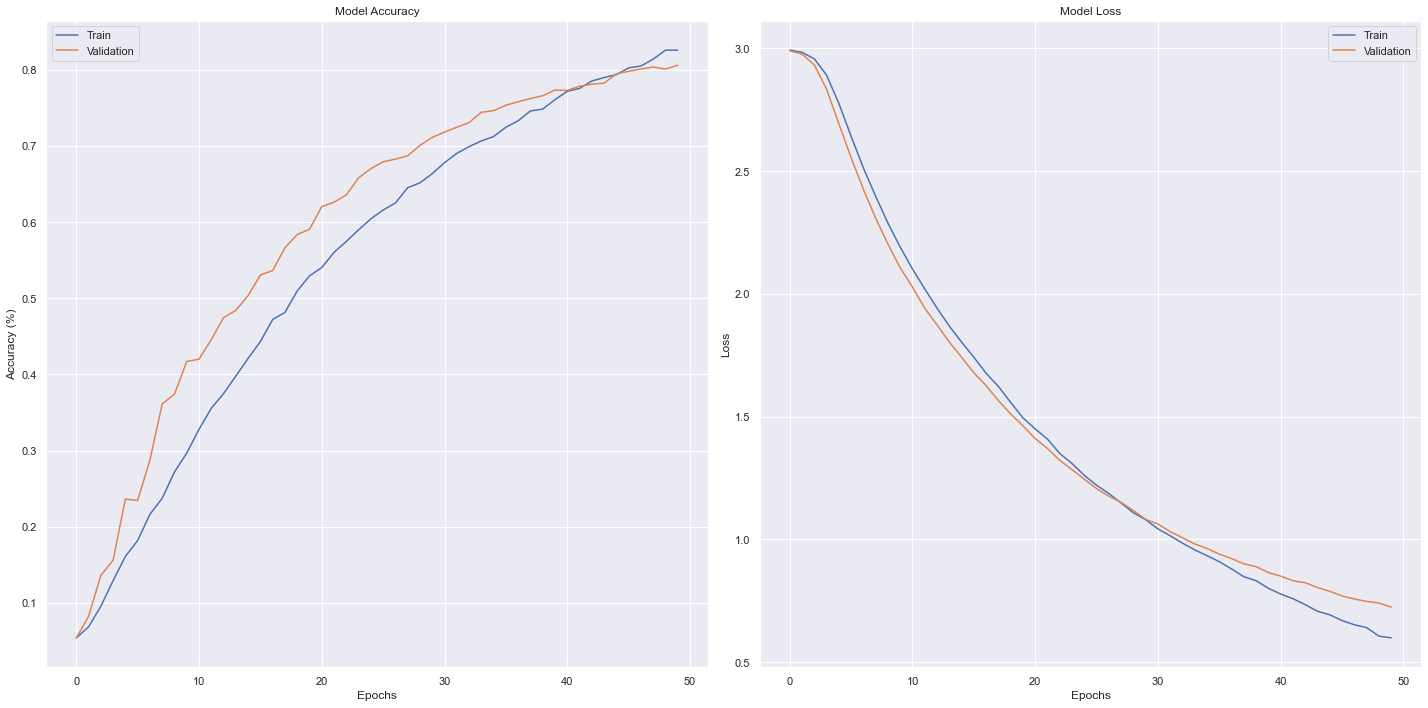

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 20))

hist_df = pd.DataFrame(hist.history)

df_loss = hist_df[['loss', 'val_loss']].copy(deep=True)
df_acc = hist_df[['accuracy', 'val_accuracy']].copy(deep=True)

df_acc.rename(columns={'accuracy': 'Train', 'val_accuracy': 'Validation'}, inplace=True)
df_loss.rename(columns={'loss': 'Train', 'val_loss': 'Validation'}, inplace=True)

ax_acc = df_acc.plot(ax=ax1, figsize=(20, 10), title='Model Accuracy')
ax_loss = df_loss.plot(ax=ax2, figsize=(20, 10), title='Model Loss')

ax_acc.set_xlabel("Epochs")
ax_acc.set_ylabel("Accuracy (%)")

ax_loss.set_xlabel("Epochs")
ax_loss.set_ylabel("Loss")

fig.tight_layout()

In [27]:
target_test.shape

(3770,)

In [28]:
predicted = [np.argmax(pred[i]) for i in range(pred.shape[0])]
# y_test2 = [np.argmax(target_test[i]) for i in range(target_test.shape[0])]

Text(111.5, 0.5, 'Predicted')

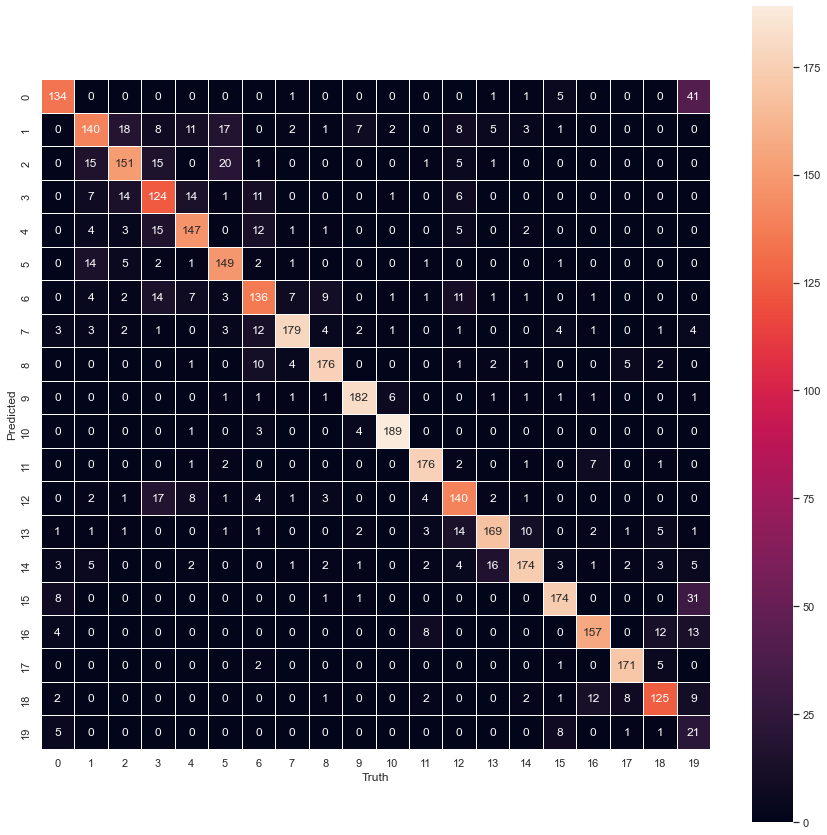

In [29]:
matrix = confusion_matrix(list(target_test), predicted)

sns.set()
plt.figure(figsize = (15, 15))

sns.heatmap(matrix.T,
            square = True,
            annot = True,
            fmt = 'd',
            cbar = True,
            linewidths = .9,
            xticklabels = np.unique(target_train).tolist(),
            yticklabels = np.unique(target_train).tolist())

plt.xlabel('Truth')
plt.ylabel('Predicted')